# Setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg as linalg
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/ml-100k/u.data",
                 sep="\t",
                 names=["userId","movieId","rating","timestamp"],
                 engine="python")
print(df.head())


   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


In [3]:
from hyper_param_search import grid_search_funksvd

# Hyper parameter search

In [4]:
lr_candidates     = [0.001, 0.005, 0.01]
lambda_candidates = [0.001, 0.01, 0.1]
K_candidates      = [10, 20, 50]
results = grid_search_funksvd(df,
                              lr_candidates,
                              lambda_candidates,
                              K_candidates,
                              n_epochs=20)
print(results.sort_values('val_rmse').head())

✔️ Grid search done, results saved to 'hyperparam_results.csv'
      lr  lambda   K  train_rmse  val_rmse
23  0.01   0.010  50    0.758847  0.931545
20  0.01   0.001  50    0.731139  0.934917
22  0.01   0.010  20    0.812454  0.936460
19  0.01   0.001  20    0.792469  0.938638
21  0.01   0.010  10    0.841406  0.942966


# Model Optimized with SGD

In [6]:
# 1. DATA PREPARATION -------------------------------------------
# keep only the three columns we need
df = df[['userId','movieId','rating']]

# map original user/movie IDs to 0-based indices
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()
u2idx = {u:i for i,u in enumerate(user_ids)}
i2idx = {m:i for i,m in enumerate(movie_ids)}
n_users, n_items = len(user_ids), len(movie_ids)

# split into 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# build list of (u_idx, i_idx, rating) for train and test
train_samples = [
    (u2idx[u], i2idx[m], r)
    for u, m, r in zip(train_df.userId, train_df.movieId, train_df.rating)
]
# for test, drop any (u,m) not seen in train
test_samples = []
for u, m, r in zip(test_df.userId, test_df.movieId, test_df.rating):
    u_idx = u2idx.get(u, None)
    i_idx = i2idx.get(m, None)
    if u_idx is not None and i_idx is not None:
        test_samples.append((u_idx, i_idx, r))

# 2. PARAMETER INITIALIZATION ----------------------------------
K        = 50      # number of latent factors
lr       = 0.01   # learning rate γ
lmbda    = 0.01    # regularization λ
n_epochs = 20      # number of SGD passes

# randomly initialize P (users) and Q (items)
P = np.random.normal(scale=0.01, size=(n_users, K))
Q = np.random.normal(scale=0.01, size=(n_items, K))

# 3. SGD TRAINING & EVALUATION ---------------------------------

# Lists to store RMSE values per epoch
train_rmse_list = []
test_rmse_list = []

# SGD training loop
for epoch in range(1, n_epochs+1):
    np.random.shuffle(train_samples)

    for u_idx, i_idx, r in train_samples:
        pred = P[u_idx].dot(Q[i_idx])
        err  = r - pred
        P[u_idx] += lr * (err * Q[i_idx] - lmbda * P[u_idx])
        Q[i_idx] += lr * (err * P[u_idx] - lmbda * Q[i_idx])

    # Compute RMSE
    train_se = sum((r - P[u].dot(Q[i]))**2 for u,i,r in train_samples)
    test_se = sum((r - P[u].dot(Q[i]))**2 for u,i,r in test_samples)
    train_rmse = np.sqrt(train_se / len(train_samples))
    test_rmse = np.sqrt(test_se / len(test_samples))

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    print(f"Epoch {epoch:02d}/{n_epochs} — "
          f"Train RMSE: {train_rmse:.4f}, "
          f"Test RMSE:  {test_rmse:.4f}")


Epoch 01/20 — Train RMSE: 3.5726, Test RMSE:  3.5680
Epoch 02/20 — Train RMSE: 1.3866, Test RMSE:  1.4136
Epoch 03/20 — Train RMSE: 1.0757, Test RMSE:  1.1064
Epoch 04/20 — Train RMSE: 0.9961, Test RMSE:  1.0292
Epoch 05/20 — Train RMSE: 0.9653, Test RMSE:  1.0004
Epoch 06/20 — Train RMSE: 0.9485, Test RMSE:  0.9857
Epoch 07/20 — Train RMSE: 0.9361, Test RMSE:  0.9785
Epoch 08/20 — Train RMSE: 0.9266, Test RMSE:  0.9705
Epoch 09/20 — Train RMSE: 0.9150, Test RMSE:  0.9631
Epoch 10/20 — Train RMSE: 0.9010, Test RMSE:  0.9551
Epoch 11/20 — Train RMSE: 0.8890, Test RMSE:  0.9523
Epoch 12/20 — Train RMSE: 0.8758, Test RMSE:  0.9459
Epoch 13/20 — Train RMSE: 0.8620, Test RMSE:  0.9428
Epoch 14/20 — Train RMSE: 0.8464, Test RMSE:  0.9388
Epoch 15/20 — Train RMSE: 0.8303, Test RMSE:  0.9351
Epoch 16/20 — Train RMSE: 0.8117, Test RMSE:  0.9320
Epoch 17/20 — Train RMSE: 0.7932, Test RMSE:  0.9279
Epoch 18/20 — Train RMSE: 0.7746, Test RMSE:  0.9274
Epoch 19/20 — Train RMSE: 0.7530, Test RMSE:  

# Training Curve

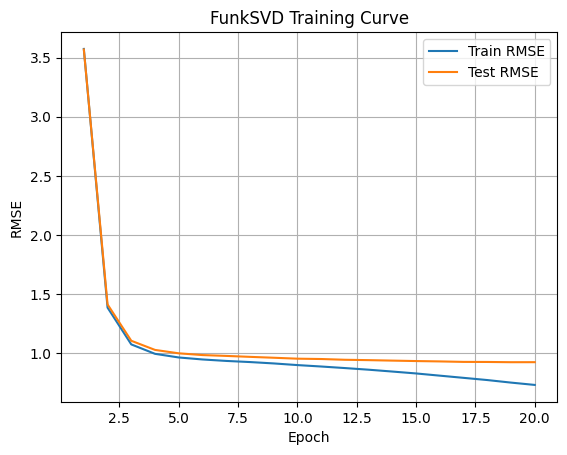

In [7]:
# 📈 Plot RMSE curve
plt.plot(range(1, n_epochs+1), train_rmse_list, label='Train RMSE')
plt.plot(range(1, n_epochs+1), test_rmse_list, label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("FunkSVD Training Curve")
plt.legend()
plt.grid(True)
plt.show()